In [20]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [21]:
import seaborn as sns

In [22]:
sns.set_context('poster', font_scale=1.25)

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from LB_D2Q9 import pipe_opencl as lb

We now want to visualize the evolution of the flow...let's see how it goes...

In [25]:
from IPython import display

It's probably easier to specify dt and dr and the dimensions. Then get everything else from that...yeah. That way the velocity is on the scale of U ~ 0.1 or so.

In [50]:
#### Input to the simulation in SI. ######
diameter = 2. # meters
length = 8. # meters

deltaP = -.1

dr = 0.02
dt = .01

viscosity = 10.**-6. # More viscous = easier to simulate!

##### Derived parameters ######
print 'Desired viscosity:' , viscosity
#Re = (input_velocity * diameter)/viscosity
#print 'Desired Re', Re

# Re is set by diameter, input_velocity, and viscosity
# Adjust dr so that mach number doers not explode!
print
print '###### Simulation Parameters #########'
print

# Solve for the desired omega...make sure it's in the correct range.


ly = int(np.ceil(diameter/dr))
lx = int(np.ceil(length/dr))
print 'ly', ly
print 'lx', lx

nx = lx + 1
ny = ly + 1

omega = .5 + (3*dt*viscosity)/(dr**2)

print 'omega:' , omega

assert (omega > 0.5) and (omega < 1)

obstacle_size=.25 # meters

Desired viscosity: 1e-06

###### Simulation Parameters #########

ly 100
lx 400
omega: 0.500075


In [51]:
nx*ny*9

364509

In [52]:
import skimage as ski
import skimage.draw

In [53]:
import sys

In [54]:
sim = lb.Pipe_Flow(lx=lx, ly=ly, dr=dr, dt=dt, omega=omega,
                  deltaP = deltaP)

# U should be on the order of 0.1, 0.2 in the simulation!
#print 'u_max in simulation:' , np.max(sim.u)

The platforms detected are:
---------------------------
Intel(R) OpenCL Intel(R) Corporation version: OpenCL 1.2 LINUX
The devices detected on platform Intel(R) OpenCL are:
---------------------------
       Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz [Type: CPU ]
Maximum clock Frequency: 2000 MHz
Maximum allocable memory size: 2062 MB
Maximum work group size 8192
Maximum work item dimensions 3
Maximum work item size [8192, 8192, 8192]
---------------------------
This context is associated with  1 devices


In [55]:
rho = sim.get_fields_on_cpu()['rho']
print np.max(rho)
print np.min(rho)

1.0
0.700748


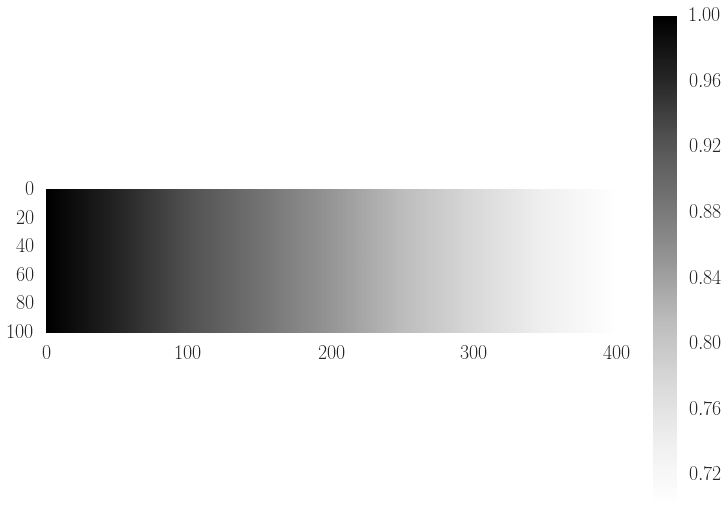

In [56]:
fields = sim.get_fields_on_cpu()
plt.imshow(fields['rho'].T)
plt.colorbar()
plt.grid(False)

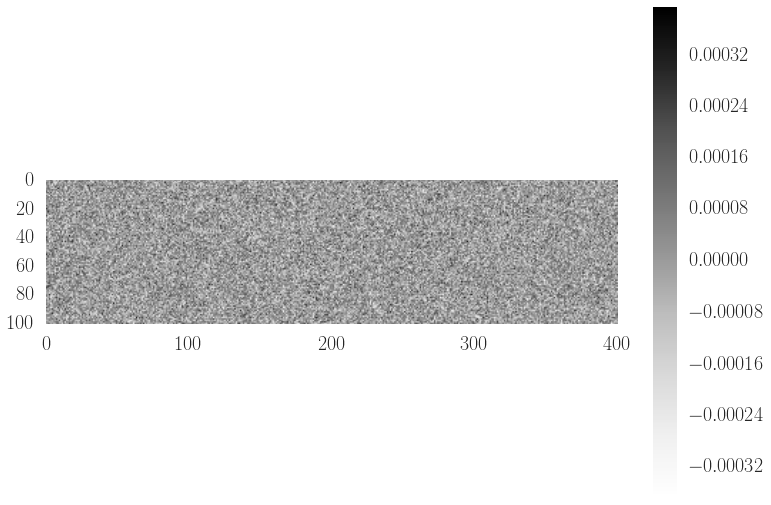

In [57]:
fields = sim.get_fields_on_cpu()
plt.imshow(fields['u'].T)
plt.colorbar()
plt.grid(False)

Yeah the boundaries still look utterly psychotic. lol. Not sure what's up with them! F & feq still look reasonable...so it's probably in an update function...

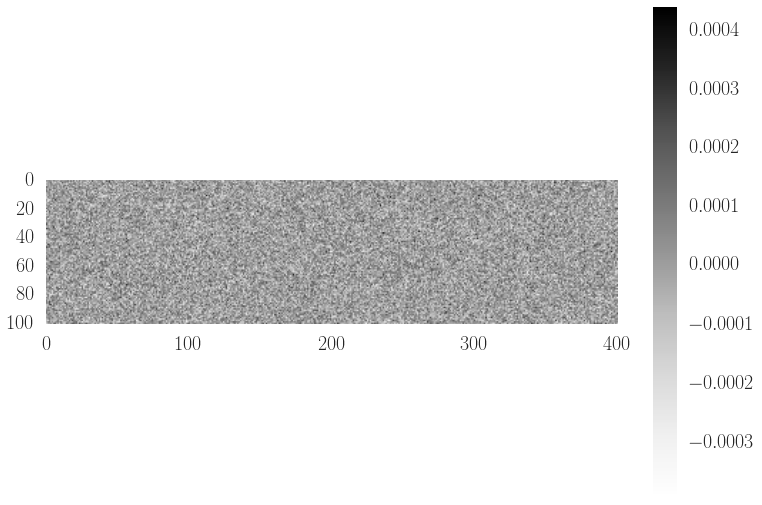

In [58]:
fields = sim.get_fields_on_cpu()
plt.imshow(fields['v'].T)
plt.colorbar()
plt.grid(False)

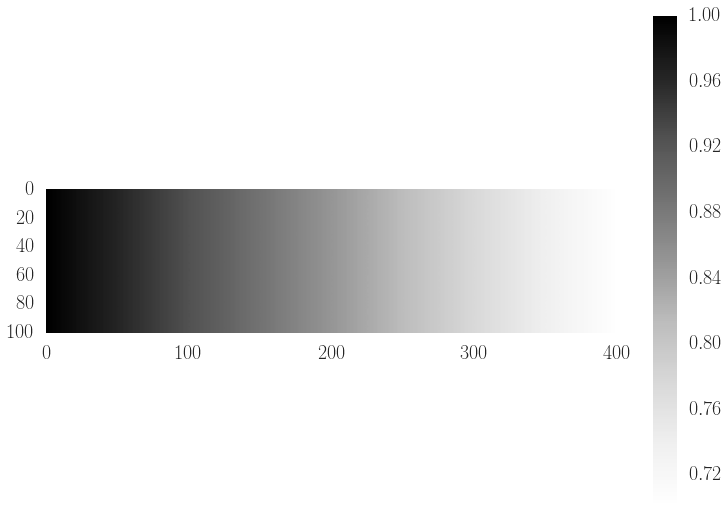

In [59]:
fields = sim.get_fields_on_cpu()
plt.imshow(np.sum(fields['feq'],axis=2).T)
plt.colorbar()
plt.grid(False)

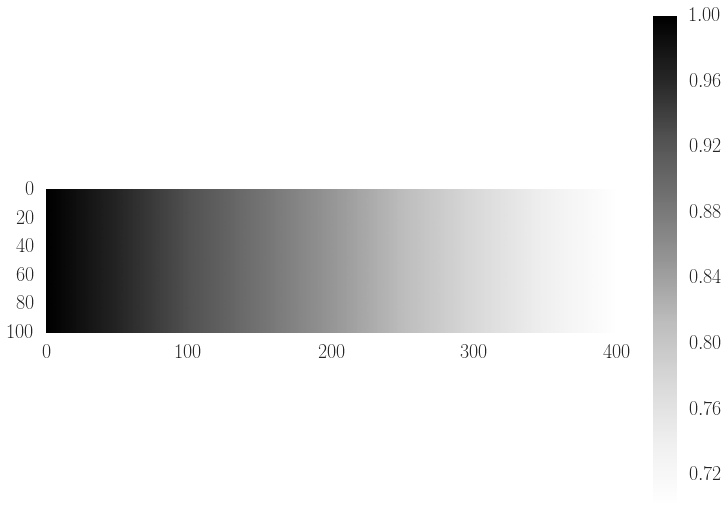

In [60]:
fields = sim.get_fields_on_cpu()
plt.imshow(np.sum(fields['f'], axis=2).T)
plt.colorbar()
plt.grid(False)

In [75]:
sim.run(10)

<matplotlib.colorbar.Colorbar instance at 0x7f3c1368c950>

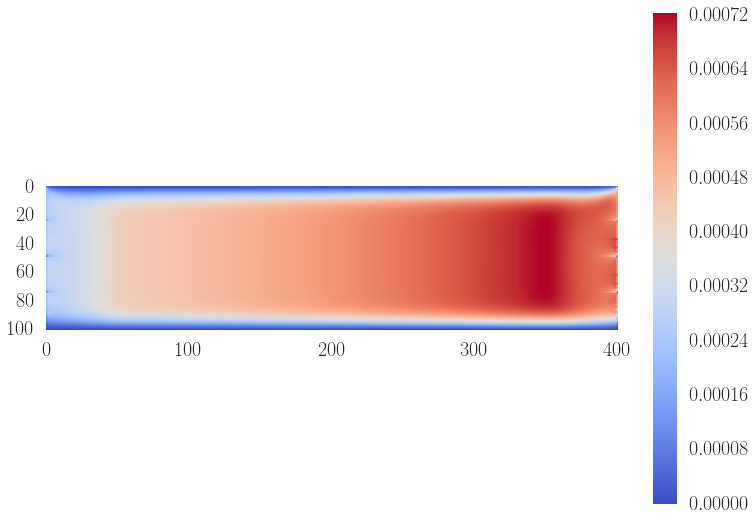

In [76]:
wat = sim.get_fields_on_cpu()['u']**2 + sim.get_fields_on_cpu()['v']**2
plt.imshow(wat.T, cmap = cm.coolwarm)
plt.grid(False)
plt.colorbar()

Yeah this is not correct lol. It explodes!

In [21]:
sim.get_fields_on_cpu()['rho']

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [        nan,         nan,         nan, ...,         nan,
                nan,  0.99958557],
       [        nan,         nan,         nan, ...,         nan,
                nan,  0.99951583],
       ..., 
       [        nan,         nan,         nan, ...,         nan,
                nan,  0.97052032],
       [        nan,         nan,         nan, ...,         nan,
                nan,  0.97044581],
       [ 0.97000003,  0.97000003,  0.97000003, ...,  0.97000003,
         0.97000003,  0.97000003]], dtype=float32)

LOL

Interesting...weird streaks are forming! Disaster...lol.

In [12]:
sim.run(100)

In [ ]:
total_num_steps = 5000
steps_per_image= 25

num_to_record = int(np.ceil(float(total_num_steps)/steps_per_image))

Re_list = []
Ma_list = []

plt.figure()
for i in range(num_to_record):
    sim.update_dimensionless_nums()
    Re_list.append(sim.Re)
    Ma_list.append(sim.Ma)
    print 'max non_dim u:', np.max(sim.u)
    print 'sum of mass' , np.sum(sim.rho)/(sim.nx*sim.ny)
    mag = np.sqrt(sim.u**2 + sim.v**2)
    plt.imshow(mag.T, cmap = cm.coolwarm)
    plt.grid(False)
    #plt.clim(vmin=0, vmax=1.)
    #if i == 0:
    #    plt.colorbar()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    sim.run(steps_per_image)
plt.clf() # This way a second figure does not appear at the end...

IDK how to convert...but let's just fit.

In [ ]:
plt.semilogy(Ma_list, ls='-', marker='.')

Nope, it's fucked! lol.

In [ ]:
plt.semilogy(Re_list, ls='-', marker='.')

Looks like it still hasn't converged. But, as expected, larger pressure differences leads to larger reynolds numbers!